# Description of the task and dataset

This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data.


1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 'jan' to 'dec'
4. day - day of the week: 'mon' to 'sun'
5. FFMC (Fine Fuel Moisture Code) - FFMC index from the FWI system: 18.7 to 96.20
6. DMC (Duff Moisture Code) - DMC index from the FWI system: 1.1 to 291.3
7. DC (Drought Code) - DC index from the FWI system: 7.9 to 860.6
8. ISI (Initial Spread Index) - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH (Relative humadity) - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84  
(this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

# Libraries

In [75]:
import pandas as pd
import numpy as np

import calendar

from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_validate, learning_curve, RandomizedSearchCV, cross_val_predict, GridSearchCV, KFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, scale, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
% matplotlib inline

from scipy.stats import median_absolute_deviation

import tensorflow.keras as tk


#Loading dataset

In [76]:
df= pd.read_csv("/content/forestfires.csv")
X = df.drop(columns=['area'],axis=1)

#encoding 
month_int = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
day_int = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5, 'sat':6, 'sun':7}

X['month']= X['month'].apply(lambda x: month_int[x])
X['day'] = X['day'].apply(lambda x: day_int[x])

#logarithm transformation
y = np.log1p(df['area']) 

# Forest fires around locations (X,Y)

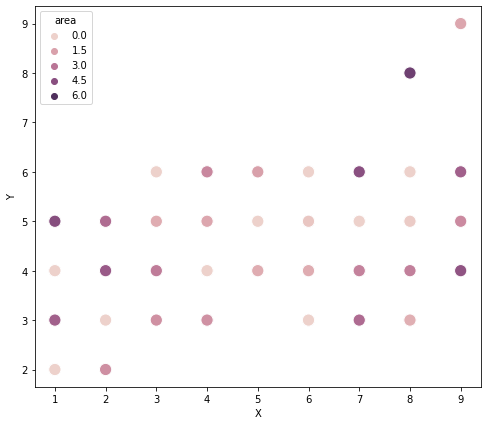

In [127]:
fig = plt.figure(figsize=(8,7))
sns.scatterplot(x=X['X'], y=X['Y'], hue=y, s=150)
plt.show()

# Temperatures at different locations

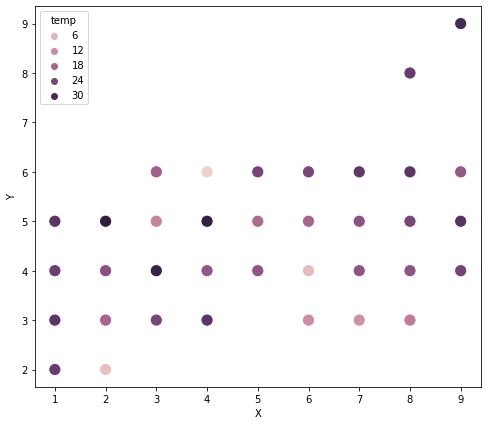

In [128]:
fig = plt.figure(figsize=(8,7))
sns.scatterplot(x=X['X'], y=X['Y'], hue=X['temp'], s=150)
plt.show()

# Feature Selection

First setup: **X, Y, month, day, FFMC, DMC, DC, ISI**  
Second setup: **X, Y, month, day, temp, RH, wind, rain**  
Third setup: **FFMC, DMC, DC, ISI**  
Fourth setup: **temp, RH, wind, rain**

In [77]:
first_setup = X[['X','Y','month','day','FFMC','DMC','DC','ISI']]
second_setup = X[['X','Y','month','day','temp','RH','wind','rain']]
third_setup = X[['FFMC','DMC','DC','ISI']]
fourth_setup =  X[['temp','RH','wind','rain']]

first_setup = StandardScaler().fit_transform(first_setup)
second_setup = StandardScaler().fit_transform(second_setup)
third_setup = StandardScaler().fit_transform(third_setup)
fourth_setup = StandardScaler().fit_transform(fourth_setup)

# Train, valid sets

In [78]:
ratio_train = 0.8
random_st = 42

x_trainF, x_validF, y_trainF, y_validF = train_test_split(first_setup,y,train_size=ratio_train, random_state=random_st)
x_trainS, x_validS, y_trainS, y_validS = train_test_split(second_setup,y,train_size=ratio_train, random_state=random_st)
x_trainT, x_validT, y_trainT, y_validT = train_test_split(third_setup,y,train_size=ratio_train, random_state=random_st)
x_trainO, x_validO, y_trainO, y_validO = train_test_split(fourth_setup,y,train_size=ratio_train, random_state=random_st)

#Multiple Regression

The best Multivariable Regression model is with **third setup** of feature selection among the others setups. R^2 is very bad, cause it predicts worse than the horizontal line (mean value).

In [79]:
model = LinearRegression()
model.fit(x_trainF,y_trainF)
y_pred = model.predict(x_validF)
print("MSE: ",mean_squared_error(y_validF, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validF,y_pred))

MSE:  2.1880124791060704
MAD:  0.21737336794330978
R^2:  0.004481216392760445


In [80]:
model = LinearRegression()
model.fit(x_trainS,y_trainS)
y_pred = model.predict(x_validS)
print("MSE: ",mean_squared_error(y_validS, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validS,y_pred))

MSE:  2.121005239122418
MAD:  0.22056661137096134
R^2:  0.03496868695264399


In [81]:
model = LinearRegression()
model.fit(x_trainT,y_trainT)
y_pred = model.predict(x_validT)
print("MSE: ",mean_squared_error(y_validT, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validT,y_pred))

MSE:  2.244642954706527
MAD:  0.14510059517715973
R^2:  -0.021284953920810645


In [146]:
model = LinearRegression()
model.fit(x_trainO,y_trainO)
y_pred = model.predict(x_validO)
print("MSE: ",mean_squared_error(y_validO, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validO,y_pred))

MSE:  2.1517602416438066
MAD:  0.08393935336798071
R^2:  0.020975538836578766


### Regression Error Characteritic Curve

In [164]:
from scipy.integrate import simps
# Defining a simple linear regression model

LR = LinearRegression()

# predicting using 10-folds cross-validation
y_pred = cross_val_predict(LR, fourth_setup, y, cv=10)

In [165]:
# Function for Regression Error Characteritic Curve

def REC(y_true , y_pred):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_true)):
            if np.linalg.norm(y_true[j] - y_pred[j]) / np.sqrt( np.linalg.norm(y_true[j]) **2 + np.linalg.norm(y_pred[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_true))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

In [166]:
Deviation , Accuracy, AUC = REC(y, y_pred)
RR = r2_score(y, y_pred)

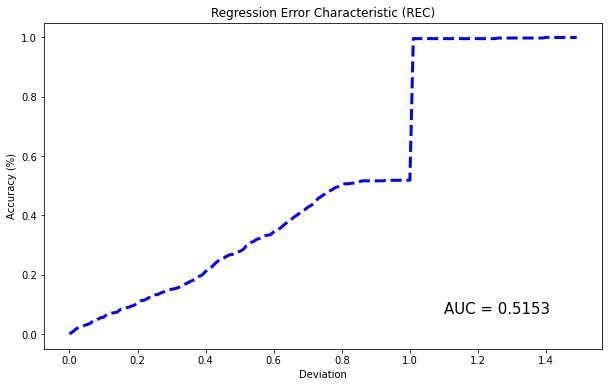

In [167]:
plt.figure(figsize=(10,6))
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()

#DecisionTree

Again, the best DecisionTree model is with **third setup** of feature selection, but R^2 is still bad.

In [83]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainF,y_trainF)
y_pred = model.predict(x_validF)
print("MSE: ",mean_squared_error(y_validF, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validF,y_pred))

MSE:  3.6029716857527707
MAD:  0.894873412468406
R^2:  -0.6393078303819133


In [84]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainS,y_trainS)
y_pred = model.predict(x_validS)
print("MSE: ",mean_squared_error(y_validS, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validS,y_pred))

MSE:  3.857605850031126
MAD:  0.0
R^2:  -0.7551632452426185


In [85]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainT,y_trainT)
y_pred = model.predict(x_validT)
print("MSE: ",mean_squared_error(y_validT, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validT,y_pred))

MSE:  2.4200491444832073
MAD:  1.0565946402915725
R^2:  -0.10109261422949567


In [86]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainO,y_trainO)
y_pred = model.predict(x_validO)
print("MSE: ",mean_squared_error(y_validO, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validO,y_pred))

MSE:  3.3015824985538043
MAD:  1.2779335951597273
R^2:  -0.5021794547908962


## Tuning Hyperparameters of the model with third setup

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=95,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')
MSE:  2.356057954689679
MAD:  0.3875454744546623
R^2:  -0.0719774094337442


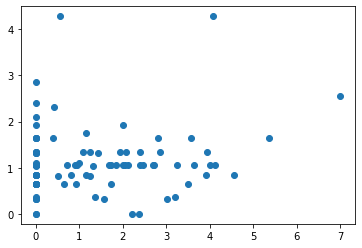

In [87]:
params = {"max_depth":range(5,20), "max_leaf_nodes":range(50,150,5)}
cv= RandomizedSearchCV(DecisionTreeRegressor(random_state=random_st), param_distributions=params, scoring='neg_mean_squared_error',cv=5,random_state=random_st)
cv.fit(x_trainT,y_trainT)
print(cv.best_estimator_)
y_pred = cv.predict(x_validT)
print("MSE: ",mean_squared_error(y_validT, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validT,y_pred))
plt.scatter(y_validT,y_pred)
plt.show()

# RandomForest

In [88]:
model = RandomForestRegressor(random_state=random_st)
model.fit(x_trainF,y_trainF)
y_pred = model.predict(x_validF)
print("MSE: ",mean_squared_error(y_validF, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validF,y_pred))

MSE:  2.3367004308851627
MAD:  0.6360679748318993
R^2:  -0.06316997403950309


In [89]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainS,y_trainS)
y_pred = model.predict(x_validS)
print("MSE: ",mean_squared_error(y_validS, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validS,y_pred))

MSE:  3.857605850031126
MAD:  0.0
R^2:  -0.7551632452426185


In [90]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainT,y_trainT)
y_pred = model.predict(x_validT)
print("MSE: ",mean_squared_error(y_validT, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validT,y_pred))

MSE:  2.4200491444832073
MAD:  1.0565946402915725
R^2:  -0.10109261422949567


In [91]:
model = DecisionTreeRegressor(random_state=random_st)
model.fit(x_trainO,y_trainO)
y_pred = model.predict(x_validO)
print("MSE: ",mean_squared_error(y_validO, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validO,y_pred))

MSE:  3.3015824985538043
MAD:  1.2779335951597273
R^2:  -0.5021794547908962


## Tuning Hyperparameters of the model with first setup

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=115,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=386, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)
MSE:  2.281953166696015
MAD:  0.45754941779998715
R^2:  -0.03826064177021382


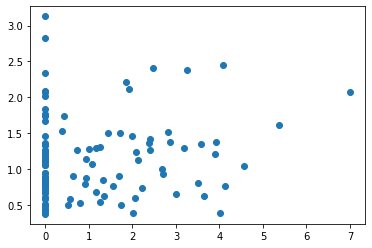

In [92]:
params = {"max_depth":range(5,23), "max_leaf_nodes":range(50,170,5),"n_estimators":range(500)}
cv= RandomizedSearchCV(RandomForestRegressor(random_state=random_st), param_distributions=params, scoring='neg_mean_squared_error',cv=5,random_state=random_st)
cv.fit(x_trainF,y_trainF)
print(cv.best_estimator_)
y_pred = cv.predict(x_validF)
print("MSE: ",mean_squared_error(y_validF, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validF,y_pred))
plt.scatter(y_validF,y_pred)
plt.show()

# Support Vector Machine (Soft)

In [93]:
x_trainF_scaled = scale(x_trainF)
x_validF_scaled = scale(x_validF)
model = SVR()
model.fit(x_trainF_scaled, y_trainF)
y_pred = model.predict(x_validF_scaled)
print("MSE: ",mean_squared_error(y_validF, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validF,y_pred))

MSE:  2.4390745117973074
MAD:  0.38664370512335955
R^2:  -0.10974892250336454


In [94]:
x_train_scaled = scale(x_trainS)
x_valid_scaled = scale(x_validS)
model = SVR()
model.fit(x_train_scaled, y_trainS)
y_pred = model.predict(x_valid_scaled)
print("MSE: ",mean_squared_error(y_validS, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validS,y_pred))

MSE:  2.521200924866604
MAD:  0.39029031044575124
R^2:  -0.14711543097692426


In [95]:
x_train_scaled = scale(x_trainT)
x_valid_scaled = scale(x_validT)
model = SVR()
model.fit(x_train_scaled, y_trainT)
y_pred = model.predict(x_valid_scaled)
print("MSE: ",mean_squared_error(y_validT, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validT,y_pred))

MSE:  2.489453407204267
MAD:  0.2811661330487531
R^2:  -0.13267070067142295


In [96]:
x_train_scaled = scale(x_trainO)
x_valid_scaled = scale(x_validO)
model = SVR()
model.fit(x_train_scaled, y_trainO)
y_pred = model.predict(x_valid_scaled)
print("MSE: ",mean_squared_error(y_validO, y_pred))
print("MAD: ", median_absolute_deviation(y_pred))
print("R^2: ", r2_score(y_validO,y_pred))

MSE:  2.424111657868092
MAD:  0.3741587105497921
R^2:  -0.1029410078844355


# Neural Network (First Setup)

In [97]:
model = tk.Sequential()
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform', input_dim=first_setup.shape[1]))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(32,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.3))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(1,activation = 'linear', kernel_initializer='uniform'))

model.compile(loss="mean_squared_error", optimizer='Adamax', metrics=['mean_squared_error'])
model.fit(x_trainF, y_trainF, epochs=150, batch_size=20, verbose=1)


Epoch 1/150
21/21 [==============================] - 1s 2ms/step - loss: 3.0870 - mean_squared_error: 3.0870
Epoch 2/150
21/21 [==============================] - 0s 1ms/step - loss: 3.0439 - mean_squared_error: 3.0439
Epoch 3/150
21/21 [==============================] - 0s 1ms/step - loss: 2.9850 - mean_squared_error: 2.9850
Epoch 4/150
21/21 [==============================] - 0s 2ms/step - loss: 2.9021 - mean_squared_error: 2.9021
Epoch 5/150
21/21 [==============================] - 0s 2ms/step - loss: 2.7496 - mean_squared_error: 2.7496
Epoch 6/150
21/21 [==============================] - 0s 2ms/step - loss: 2.5332 - mean_squared_error: 2.5332
Epoch 7/150
21/21 [==============================] - 0s 2ms/step - loss: 2.2140 - mean_squared_error: 2.2140
Epoch 8/150
21/21 [==============================] - 0s 2ms/step - loss: 2.0369 - mean_squared_error: 2.0369
Epoch 9/150
21/21 [==============================] - 0s 2ms/step - loss: 1.9241 - mean_squared_error: 1.9241
Epoch 10/150
21/21 

In [98]:
y_pred = model.predict(x_validF)
print('MSE: ', mean_squared_error(y_validF, y_pred))
print('MAD: ', median_absolute_deviation(y_pred[0]))
print('R^2: ', r2_score(y_validF, y_pred))

MSE:  2.2155338170839958
MAD:  0.0
R^2:  -0.008040654103253164


# Neural Network (Second Setup)

In [99]:
model = tk.Sequential()
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform', input_dim=second_setup.shape[1]))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(32,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.3))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(1,activation = 'linear', kernel_initializer='uniform'))

model.compile(loss="mean_squared_error", optimizer='Adamax', metrics=['mean_squared_error'])
model.fit(x_trainS, y_trainS, epochs=100, batch_size=15, verbose=0)

y_pred = model.predict(x_validS)
print('MSE: ', mean_squared_error(y_validS, y_pred))
print('MAD: ', median_absolute_deviation(y_pred[0]))
print('R^2: ', r2_score(y_validS, y_pred))


MSE:  2.1338137276973868
MAD:  0.0
R^2:  0.02914098208909144


# Neural Network (Thrid Setup)

In [100]:
model = tk.Sequential()
model.add(tk.layers.Dense(4,activation = 'linear', kernel_initializer='uniform', input_dim=third_setup.shape[1]))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.3))
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(4,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(1,activation = 'linear', kernel_initializer='uniform'))

model.compile(loss="mean_squared_error", optimizer='Adamax', metrics=['mean_squared_error'])
model.fit(x_trainT, y_trainT, epochs=100, batch_size=15, verbose=0)

y_pred = model.predict(x_validT)
print('MSE: ', mean_squared_error(y_validT, y_pred))
print('MAD: ', median_absolute_deviation(y_pred[0]))
print('R^2: ', r2_score(y_validT, y_pred))


MSE:  2.21717570422613
MAD:  0.0
R^2:  -0.008787692571345262


# Neural Network (Fourth Setup)

In [101]:
model = tk.Sequential()
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform', input_dim=fourth_setup.shape[1]))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(32,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.3))
model.add(tk.layers.Dense(16,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(8,activation = 'linear', kernel_initializer='uniform'))
model.add(tk.layers.Dropout(0.2))
model.add(tk.layers.Dense(1,activation = 'linear', kernel_initializer='uniform'))

model.compile(loss="mean_squared_error", optimizer='Adamax', metrics=['mean_squared_error'])
model.fit(x_trainO, y_trainO, epochs=100, batch_size=15, verbose=0)

y_pred = model.predict(x_validO)
print('MSE: ', mean_squared_error(y_validO, y_pred))
print('MAD: ', median_absolute_deviation(y_pred[0]))
print('R^2: ', r2_score(y_validO, y_pred))


MSE:  2.1626600524367885
MAD:  0.0
R^2:  0.01601625890294167


# Polynomial Regression

In [115]:
#First Setup
poly= PolynomialFeatures(degree = 2)
x_poly_trainF  = poly.fit_transform(x_trainF)
x_poly_validF = poly.transform(x_validF)

model = LinearRegression()
model.fit(x_poly_trainF, y_trainF)
y_pred = model.predict(x_poly_validF)
print('MSE: ', mean_squared_error(y_validF, y_pred))
print('MAD: ', median_absolute_deviation(y_pred))
print('R^2: ', r2_score(y_validF, y_pred))

MSE:  2.292881642186692
MAD:  0.4226846966333737
R^2:  -0.043232963788964573


In [117]:
#Second Setup, no need for Third setup and Fourth setup
poly= PolynomialFeatures(degree = 2)
x_poly_trainS  = poly.fit_transform(x_trainS)
x_poly_validS = poly.transform(x_validS)

model = LinearRegression()
model.fit(x_poly_trainS, y_trainS)
y_pred = model.predict(x_poly_validS)
print('MSE: ', mean_squared_error(y_validS, y_pred))
print('MAD: ', median_absolute_deviation(y_pred))
print('R^2: ', r2_score(y_validS, y_pred))

MSE:  2.298257271660168
MAD:  0.35157356213498453
R^2:  -0.0456788091237883
